# Анализ стратегии взаимодействия с клиентами сети фитнес-центров 

Необходимо провести анализ анкет клиентов фитнес клуба и подготовить план действий по их удержанию.

##### Исследование разделим на несколько частей.

##### Шаг 1. Изучение общей информации и первичная подготовка данных:
* [1. Изучение файлов с данными, получение общей информации, загрузка библиотек.](#step1)

##### Шаг 2. Исследовательский анализ данных
* [1. Изучение средних показателей признаков.](#step2_1)
* [2. Построение графиков и изучение матрицы корреляций между признаками](#step2_2)

##### Шаг 3.  Построение модели прогнозирования оттока клиентов
* [1. Подготовка данных и обучение моделей.](#step3_1)
* [2. Расчет метрик. Выбор наилучшей модели.](#step3_2)

##### Шаг 4. Кластеризация пользователей
* [1. Обучение модели кластеризации на основании алгоритма K-Means.](#step4_1)
* [2. Анализ сравнений кластеров.](#step4_2)


##### Шаг 5. Общий вывод
* [1. Формирование общих выводов и рекомендаций по результатам исследования.](#step5)

### Шаг 1. Изучение общей информации и первичная подготовка данных:
<a id='step1'></a>

In [1]:
# Загрузим неоюбходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
df=pd.read_csv('gym_churn.csv', sep=",")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


В таблице df содержаться данные об 4000 клиентах сети фитнес клубов: 
 - факт оттока в текущем месяце
 - пол;
 - проживание или работа в районе, где находится фитнес-центр;
 - сотрудник компании-партнёра клуба;
 - факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
 - наличие контактного телефона;
 - возраст;
 - время с момента первого обращения в фитнес-центр (в месяцах).
 - длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
 - срок до окончания текущего действующего абонемента (в месяцах);
 - факт посещения групповых занятий;
 - средняя частота посещений в неделю за все время с начала действия абонемента;
 - средняя частота посещений в неделю за предыдущий месяц;
 - суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.  
 
В данных отсутствуют пропуски, типы данных в столбцах - корректны.

**Необходимо научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
выделить несколько наиболее ярких групп и охарактеризовать их основные свойства; проанализировать основные признаки, наиболее сильно влияющие на отток**

### Шаг 2. Исследовательский анализ данных (EDA)

#### 2.1. Изучение средних показателей признаков
<a id='step2_1'></a>

Рассмотрим основные статистики признаков и целевой переменной

In [5]:
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**В целом из 4000 клиентов в отток попало 26,5%. Мужчин и женщин в выборке примерно поровну. Средний возраст клиента 29 лет. 84% клиентов либо живут, либо работают недалеко от фитнес-клуба. 48% работают в компании-партнере. 30% пришли по акции "Приведи друга". 41% посещают групповые занятия. В среднем клиент посещает зал 1,76 раз в неделю.** 

Переменные Age и Avg_additional_charges_total имеют очень разные по величине стандартные отклонения.
Это говорит о том, что переменные нужно стандартизировать перед обучением.

In [6]:
churn_groups=df.groupby(by='Churn').mean()
churn_groups

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Рассмотрим средние показатели признаков по "отпавшим" и оставшимся клиентам. В группе оттока более низкий возраст, более маленький срок абонемента. Эти клиенты меньше посещают групповые занятия, тратят меньше денег на дополнительные услуги и в среднем реже посещают спортзал. 

In [7]:
cat_col=['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits']

In [8]:
data_col=['Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month']

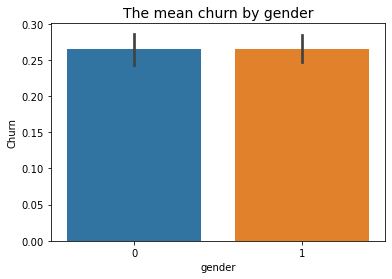

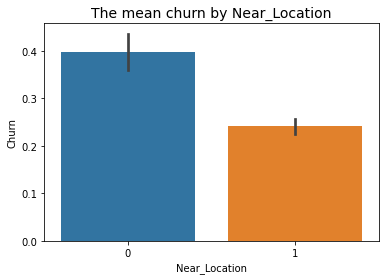

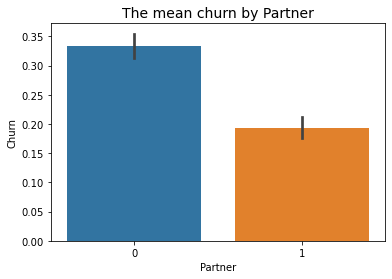

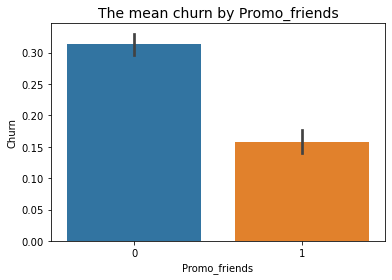

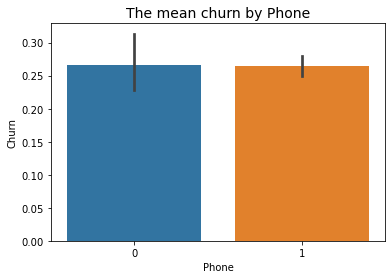

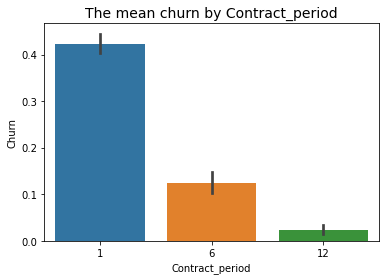

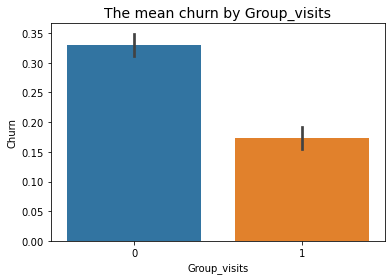

In [9]:
for col in cat_col:
    sns.barplot(y="Churn", x=col, data=df) 
    plt.title(f"The mean churn by {col}", fontsize=14)
    plt.show();

Средние показатели оттока ниже в группе клиентов, которые либо живут, либо работают недалеко от фитнес-клуба; пришли по промо-акции, покупают более длительные абонементы, посещают групповые занятия.

In [10]:
df['Churn_cat'] = df['Churn'] 

In [11]:
df.loc[df['Churn']==1, 'Churn_cat']= 'get_away'

In [12]:
df.loc[df['Churn']==0, 'Churn_cat']= 'stay'

Разберем распределение признаков на графиках

#### 2.2. Построение графиков распределения признаков
<a id='step2_1'></a>

Построем гистограммы распределения в разрезе исследуемого показателя (факта оттока).

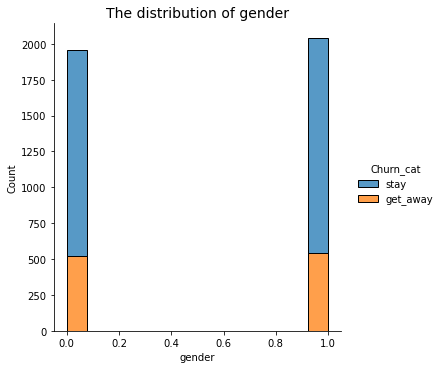

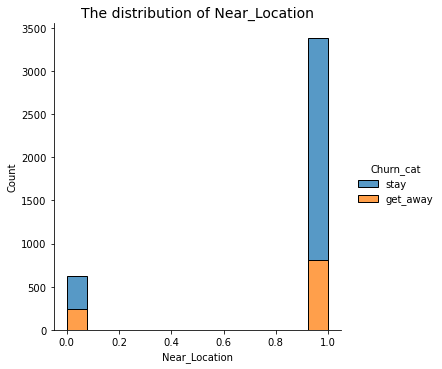

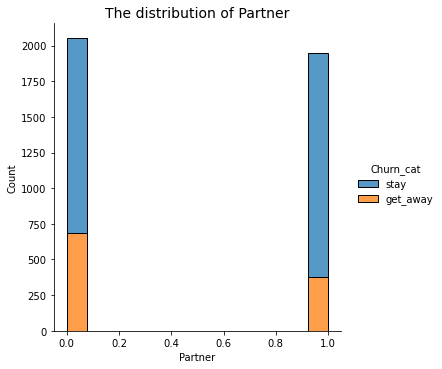

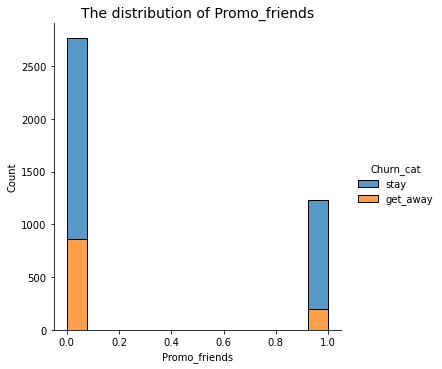

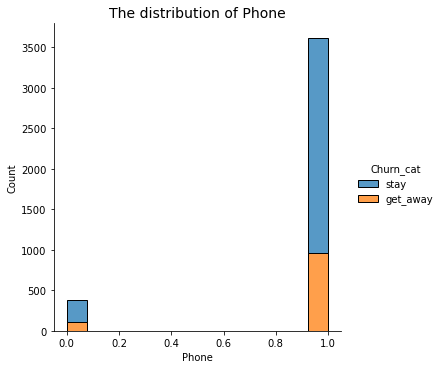

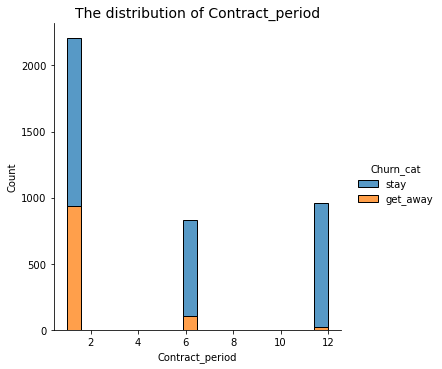

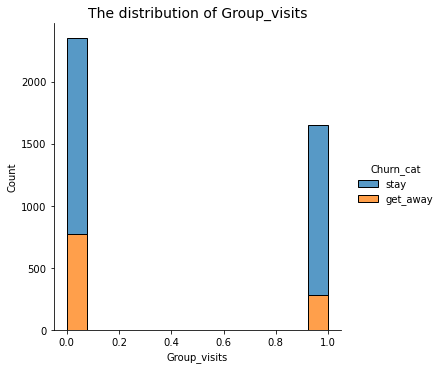

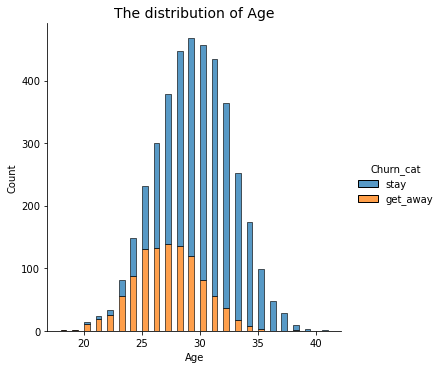

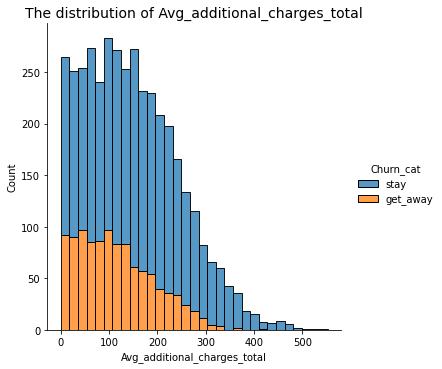

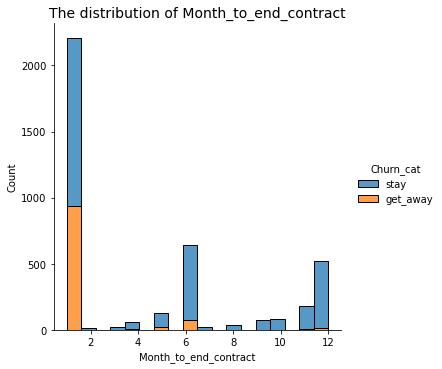

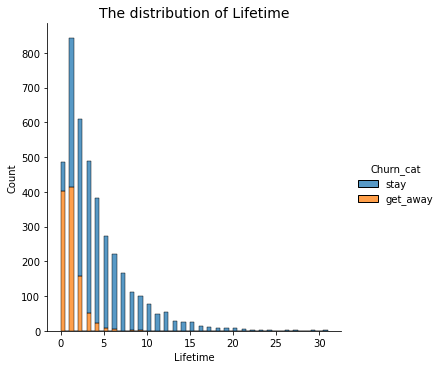

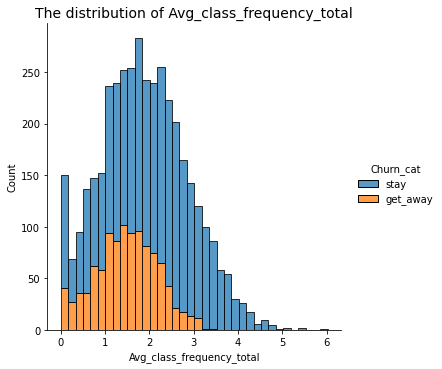

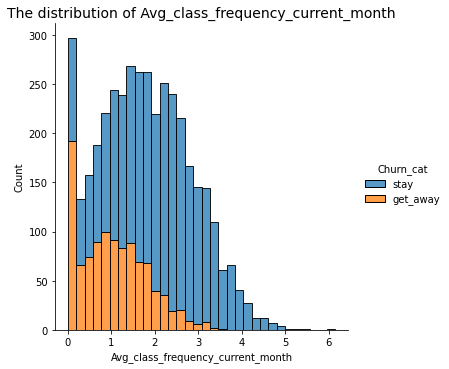

In [13]:
for col in df.drop(['Churn', "Churn_cat"], axis = 1).columns:
    sns.displot(df, x=col, hue='Churn_cat', multiple="stack")
    plt.title(f"The distribution of {col}", fontsize=14);

**Отток практически не зависит от пола и факта указания в анкете номера телефона. Отток ниже в группах работников компаний-партнеров, клиентов, пришедших по рекомендации друзей, клиентов групповых занятий, а также клиентов проживающих или работающих в районе, где находится фитнес-центр. Также отток ниже в группах с более длительным абонементом. Чем дольше клиент остается с нами, тем ниже процент оттока.**

Рассмотрим матрицу коррреляций признаков между собой

In [14]:
corr_m = df.corr()

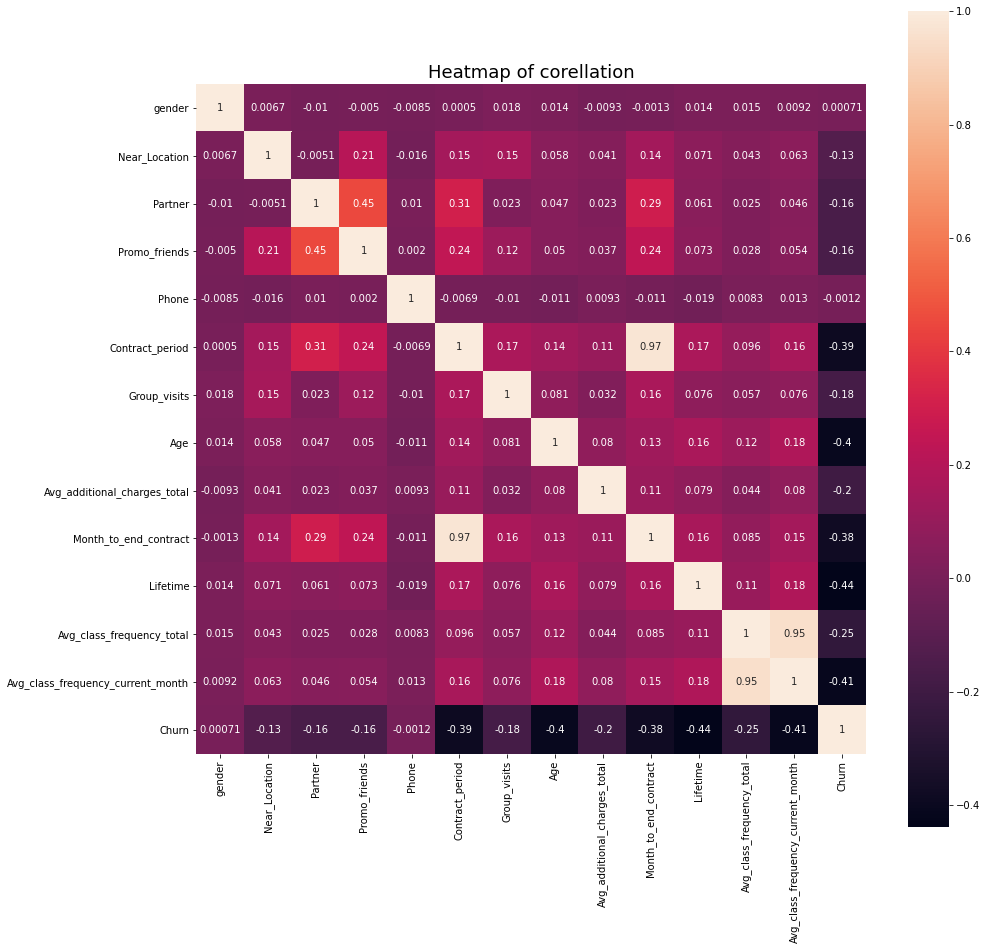

In [15]:
plt.figure(figsize=(15,15))
sns.heatmap(corr_m, square = True, annot = True)
plt.title('Heatmap of corellation', fontsize=18)
plt.show();

Сильную взаимосвязь демонстрируют 2 пары признаков: Период абонемента-количество оставшихся месяцев до конца абонемента и Среднее число посещений в неделю за последний месяц - Среднее число посещений в неделю с начала действия абонемента. Необходимо учитывать данные взаимосвязи при интерпритации показателей влияния признаков.

**Вывод по шагу 2:**
- В целом из 4000 клиентов в отток попало 26,5%. 
- Мужчин и женщин в выборке примерно поровну. Средний возраст клиента 29 лет. В среднем клиент посещает зал 1,76 раз в неделю
- 84% клиентов либо живут, либо работают недалеко от фитнес-клуба, 48% работают в компании-партнере, 30% пришли по акции "Приведи друга", 41% посещают групповые занятия.
- В группе "отпавших" клиентов более низкий средний возраст, более маленький срок абонемента. Эти клиенты меньше посещают групповые занятия, тратят меньше денег на дополнительные услуги и в среднем реже посещают спортзал. 
- Отток практически не зависит от пола и факта указания в анкете номера телефона. 
- Отток ниже в группах работников компаний-партнеров, клиентов, пришедших по рекомендации друзей, клиентов групповых занятий, а также клиентов проживающих или работающих в районе, где находится фитнес-центр. 
- Среди признаков сильную взаимосвязь демонстрируют 2 пары признаков: Период абонемента-количество оставшихся месяцев до конца абонемента и Среднее число посещений в неделю за последний месяц - Среднее число посещений в неделю с начала действия абонемента.


### Шаг 3. Постройте модель прогнозирования оттока клиентов

#### 3.1. Подготовка данных и обучение моделей.
<a id='step3_1'></a>

Сначала посмотрим как соотносятся группы по оттоку:

In [16]:
print('Соотношение классов:\n', df['Churn'].value_counts())

Соотношение классов:
 0    2939
1    1061
Name: Churn, dtype: int64


Разобьем данные на обучающую и валидационную выборку функцией train_test_split().

In [17]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(['Churn', "Churn_cat"], axis = 1)
y = df['Churn']

In [18]:
# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

In [19]:
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [20]:
# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Обучим модель на train-выборке двумя способами:
- логистической регрессией,
- случайным лесом.

In [21]:
lr_model = LogisticRegression(random_state=0)

In [22]:
lr_model.fit(X_train_st, y_train)

LogisticRegression(random_state=0)

In [23]:
lr_predictions = lr_model.predict(X_test_st) 
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

In [24]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)

In [25]:
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)

RandomForestClassifier(random_state=0)

In [26]:
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1] 

#### 3.2. Расчет метрик. Выбор наилучшей модели.
<a id='step3_2'></a>

Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Для печати метрик напишем функцию print_all_metrics.

In [27]:
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [28]:
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.94
	Precision: 0.90
	Recall: 0.85


In [29]:
# выведем все метрики
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')


Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.83


**Модель логистической регрессии в данном случае предпочтительна, т.к. показывает более высокие показатели метрик Precision и Recall.**

Упорядочим наши признаки по степени влияния на показатель оттока.

In [30]:
importances = pd.DataFrame(data=lr_model.coef_, columns=X.columns).T

In [31]:
importances.columns=['coef']

In [32]:
importances['coef_abs']=importances['coef'].abs()

In [33]:
importances.sort_values(by='coef_abs', ascending=False)

,coef,coef_abs
Avg_class_frequency_current_month,-4.213410,4.213410
Lifetime,-3.581257,3.581257
Avg_class_frequency_total,3.111962,3.111962
Age,-1.167067,1.167067
Contract_period,-0.703639,0.703639
Month_to_end_contract,-0.631972,0.631972
Avg_additional_charges_total,-0.571299,0.571299
Group_visits,-0.401414,0.401414
Promo_friends,-0.143413,0.143413
Partner,-0.066479,0.066479


Наибольшее влияние показывает признак: среднее количество посещений в неделю, далее идет показатель времяени с момента первого обращения в фитнес-центр. Топ-3 признаков замыкает возраст клиента. Минимальное влияние оказывают такие показатели как пол и телефон.

**Вывод по шагу 3:**  

Мы построили модели прогнозирования оттока пользователей 2 методами:
- логистической регрессией,
- случайным лесом.

**Модель логистической регрессии лучше прогнозирует отток пользователей, о чем свидетельствует более высокие показатели метрик Precision и Recall.**

**Топ-3 признаков по влиянию на итоговый показатель оттока: Время с первого посещения фитнес-клуба, среднее число посещений в неделю и возраст клиента.**

### Шаг 4. Сделайте кластеризацию клиентов

#### 4.1. Обучение модели кластеризации на основании алгоритма K-Means.
<a id='step4_1'></a>

Проведем кластеризацию объектов (клиентов). В первую очередь стандартизируем данные.


In [34]:
sc = StandardScaler()

In [35]:
X_sc = sc.fit_transform(X)

Построем матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.

In [36]:
linked = linkage(X_sc, method = 'ward') 

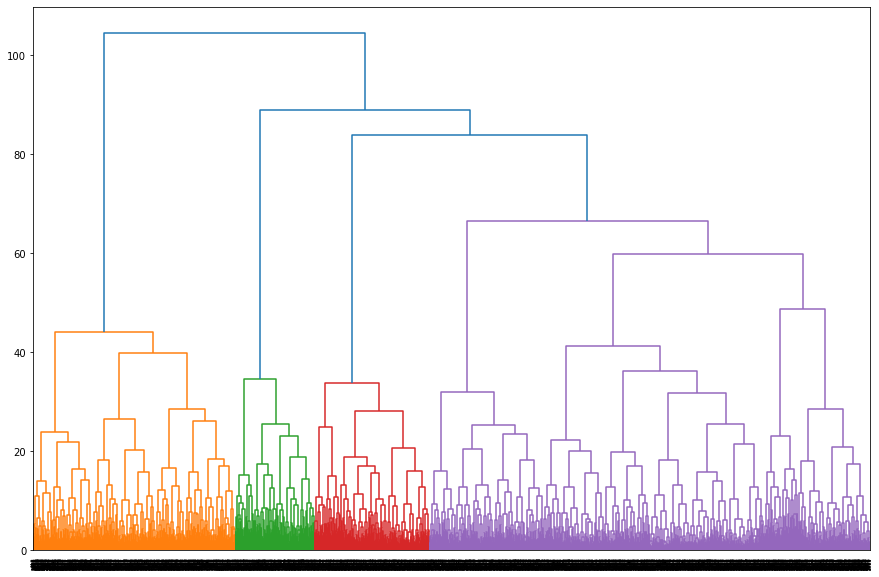

In [37]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Зададим число кластеров равным 5.

In [38]:
km = KMeans(n_clusters = 5, random_state=0) # задаём число кластеров, равное 5

In [39]:
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров 

In [40]:
df['groups']=labels

#### 4.2. Анализ сравнений кластеров.
<a id='step4_2'></a>

Посмотрим на средние значения признаков для кластеров. 

In [41]:
df.groupby(by='groups').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
groups,,,,,,,,,,,,,,
0,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
1,0.480787,0.812559,0.000000,0.086223,1.000000,1.866917,0.325211,28.145267,131.369042,1.791003,2.345829,1.325865,1.086883,0.550141
2,0.559567,0.858002,0.338147,0.197353,0.998797,2.730445,0.448857,30.196149,164.579011,2.519856,5.010830,2.928140,2.934140,0.048135
3,0.509603,0.750320,1.000000,0.451985,1.000000,2.554417,0.303457,28.499360,129.812508,2.370038,2.832266,1.355379,1.176172,0.395647
4,0.495726,0.943376,0.752137,0.541667,1.000000,11.352564,0.564103,29.993590,164.563799,10.376068,4.817308,2.028169,2.020129,0.023504


**Отток во 2 и 4 группах минимален, 5% и 2 % соответственно. 4 группа - клиенты с долгосрочными абонементами. 2 группа - с высоким показателем средненедельных посещений.
Самая проблемная группа - 1, в ней 55% оттока. Это группа с минимальными по длительности абонементами и самым низким средним возрастом. Они ходят 1-3 месяца и уходят.
В 0 группе отток на уровне 27%, в 3 - 40%.**

Построем распределения признаков для кластеров. Сначала для "категориальных" переменных.

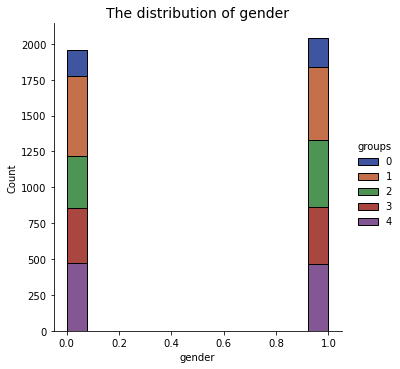

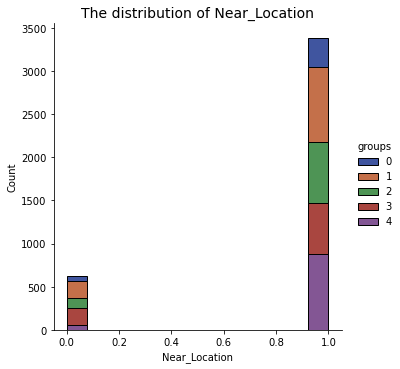

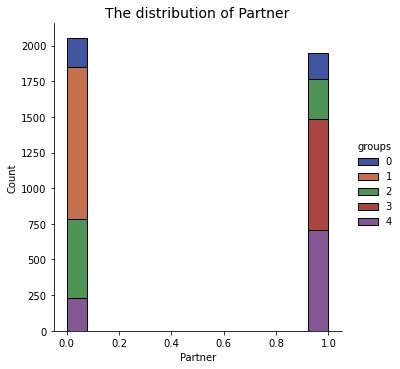

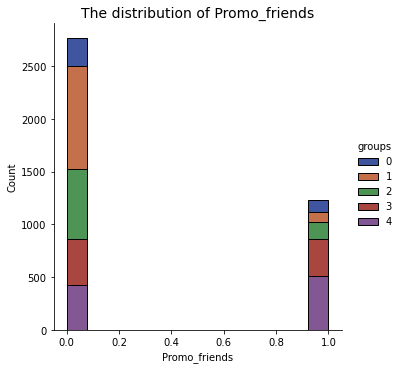

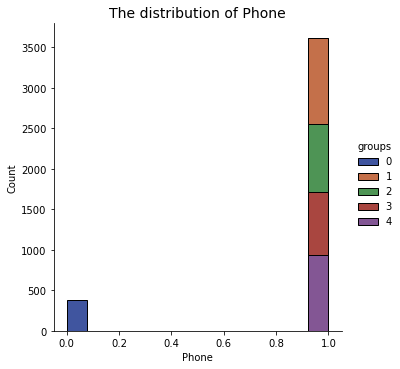

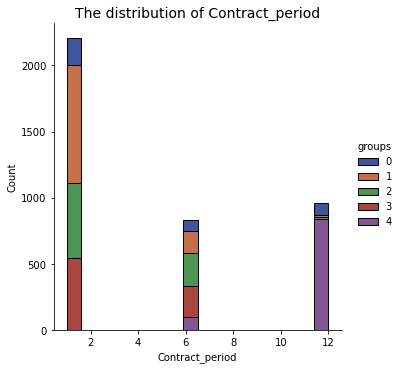

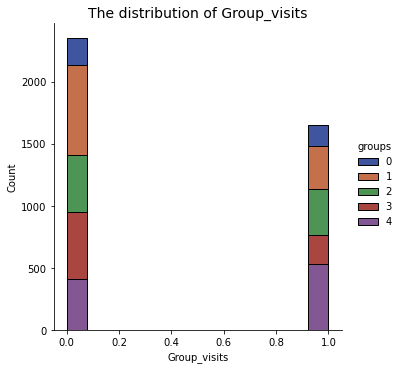

In [42]:
for col in cat_col:
    sns.displot(df, x=col, hue='groups', palette="dark", multiple="stack")
    plt.title(f"The distribution of {col}", fontsize=14);

Пол, расположение вблизи клуба, посещение групповых занятий - эти признаки распределены по группам более-менее равномерно. В 3 группе большинство клиентов - работники фирм-партнеров, а в 1 группе таких клиентов нет. Также в 1 группе меньшее из всех групп количество клиентов пришло по акции "Приведи друга", а оснавная часть абонементов в этой группе приобретена на 1 месяц. Неудивительно, что в этой группе наибольшее число оттоков. Клиенты 4 группы в основном приобретают абонементы на год. 

Для числовых переменных построем kdeplot.

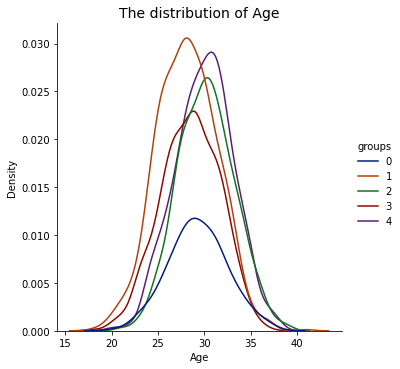

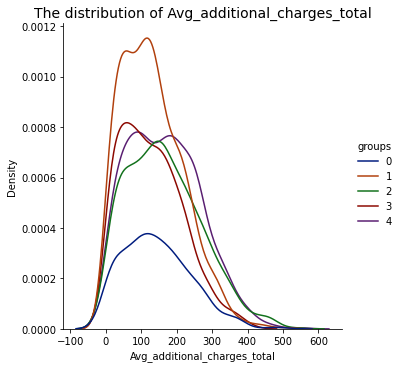

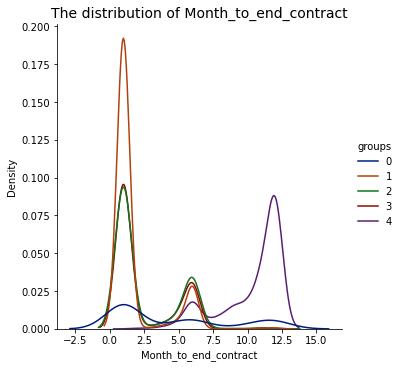

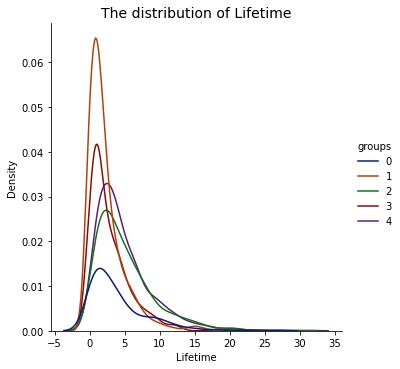

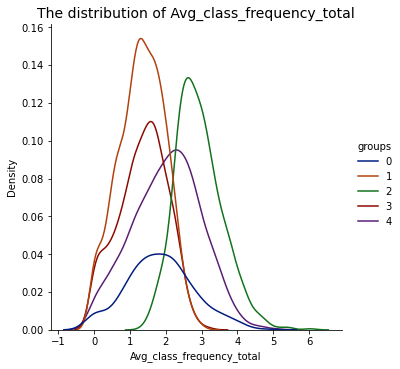

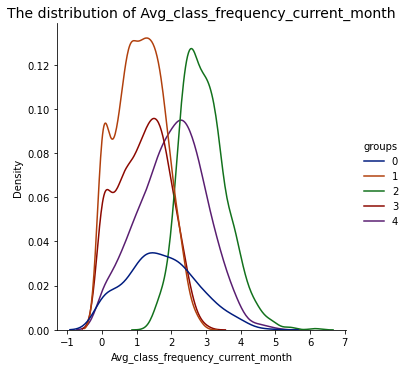

In [43]:
for col in data_col:
    sns.displot(df, x=col, hue='groups', kind="kde", palette="dark")
    plt.title(f"The distribution of {col}", fontsize=14);

Опасным моментом считаю, что число клиентов 1 группы - достаточно велико. Средний возраст в 1 группе ниже, чем в других. Они реже посещают спортзал. Лидеры по посещениям - клиенты 2 группы.

Еще раз взглянем на показатели оттока по группам.

In [44]:
df.groupby(by='groups')['Churn'].mean()

groups
0    0.267532
1    0.550141
2    0.048135
3    0.395647
4    0.023504
Name: Churn, dtype: float64

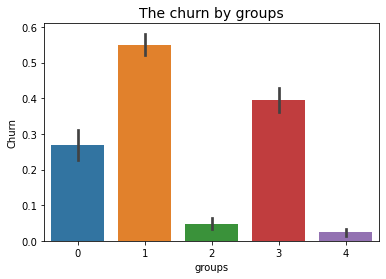

In [45]:
sns.barplot(y="Churn", x='groups', data=df) 
plt.title("The churn by groups", fontsize=14);

2 и 4 группа кллиентов - наш костяк, который приносит основную прибыль и остается с нами надолго. 1 группа - клиенты, которые недавно прибегли к нашим услугам (и 55% клиентов они видимо не понравились). Наша задача - выяснить, что их не устраивает и постараться перевести их отношения с фитнес-клубом в более долгосрочные. 0 и 3 - пограничные группы с достаточно высоким оттоком.

### Шаг 5. Формирование общих выводов и рекомендаций по результатам исследования.
<a id='step5'></a>

**Проведен анализ стратегии взаимодействия с клиентами в сети фитнес-клубов «Культуриста-датасаентиста».**
- В целом из 4000 клиентов в отток попало 26,5%. 
- Мужчин и женщин в выборке примерно поровну. Средний возраст клиента 29 лет. В среднем клиент посещает зал 1,76 раз в неделю
- 84% клиентов либо живут, либо работают недалеко от фитнес-клуба, 48% работают в компании-партнере, 30% пришли по акции "Приведи друга", 41% посещают групповые занятия.


**Сформирована модель прогнозирования оттока пользователей с помощью алгоритма логистической регрессии.**

- **Топ-3 признаков по влиянию на итоговый показатель оттока: Время с первого посещения фитнес-клуба, среднее число посещений в неделю и возраст клиента.**
- Отток ниже в группах с более длительным абонементом. Чем дольше клиент остается с нами, тем ниже процент оттока.
- В группе "отпавших" клиентов более низкий средний возраст, более маленький срок абонемента. Эти клиенты меньше посещают групповые занятия, тратят меньше денег на дополнительные услуги и в среднем реже посещают спортзал. 
- Отток практически не зависит от пола и факта указания в анкете номера телефона. 
- Отток ниже в группах работников компаний-партнеров, клиентов, пришедших по рекомендации друзей, а также клиентов проживающих или работающих в районе, где находится фитнес-центр. 


**Проведена кластеризация пользователей на 5 групп.**

2 и 4 группа кллиентов - наш костяк, который приносит основную прибыль и остается с нами надолго. 1 группа - клиенты, которые недавно прибегли к нашим услугам (и 55% клиентов они видимо не понравились). Наша задача - выяснить, что их не устраивает и постараться перевести их отношения с фитнес-клубом в более долгосрочные. 0 и 3 - пограничные группы с достаточно высоким оттоком.

**Основные рекомендации по итогам исследования:**

1.  Выгоднее продавать больше долгосрочных абонементов - на них отток ниже. 
2.  Можно заключить договора с другими компаниями, такие клиенты реже уходят. 
3.  Заинтересовать клиентов групповыми занятиями. Првести опрос, чем бы хотели заниматься в группе, возможно внести изменения в расписание или найти необходимого тренера. 
4.  Не забывать устраивать промо-акции. По ним приходят много клиентов, которые остаются. 
5.  Предложить действующим клиентам с краткосрочными абонементами скидки на длительные абонементы при рекомендации друзьям по акции.
6.  Можно больше ориентироваться на клиентов 30+. Они более стабильно посещают спортзал.
7.  Проводить анкетирование клиентов, с высокой вероятностью оттока. Их недовольство - наши возможные точки для роста.
8.  Делать предложения по новым, более долгосрочным контрактам на последнем месяце действия контракта (на нем максимальный отток).